In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from string import ascii_letters, whitespace
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
import cv2
import os
from keras.applications import vgg19
from time import sleep
from IPython.display import display, Image as IPImage
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from PIL import Image
from transformers import pipeline, AutoTokenizer, TFAutoModelForQuestionAnswering

text = "ukr.txt"

data = pd.read_csv(text, delimiter='\t', header=None).head(10000)
data.rename(columns={0: "English", 1: "Ukraine"}, inplace=True)
data = data.drop(2, axis=1)

C:\Users\gesta\pythonlabs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Завдання 1
## Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
## Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

In [4]:
def clean_text(text):
    cyrillic_letters = u"абвгдежзиійклмнопрстуфхцчшщьєюяАБВГДЕЖЗИІЙКЛМНОПРСТУФХЦЧШЩЬЄЮЯ"
    allowed_chars = cyrillic_letters + ascii_letters + whitespace
    result = "".join([c for c in text if c in allowed_chars])
    result = result.lower()
    return result

data["English"] = data["English"].apply(clean_text)
data["Ukraine"] = data["Ukraine"].apply(clean_text)
data = data.drop_duplicates(subset='English')

In [5]:
def tokenize_sequences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer.texts_to_sequences(texts), tokenizer

def pad_sequences_to_maxlen(sequences, maxlen=None):
    return pad_sequences(sequences, maxlen=maxlen, padding='post')

def preprocess_data(x, y):
    preprocess_x, x_tokenizer = tokenize_sequences(x)
    preprocess_y, y_tokenizer = tokenize_sequences(y)

    preprocess_x = pad_sequences_to_maxlen(preprocess_x)
    preprocess_y = pad_sequences_to_maxlen(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tokenizer, y_tokenizer

In [6]:
preproc_english_sentences, preproc_ukr_sentences, english_tokenizer, ukr_tokenizer = preprocess_data(
    data['English'].values, data['Ukraine'].values)

max_english_seq_length = preproc_english_sentences.shape[1]
max_ukr_seq_length = preproc_ukr_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
ukr_vocab_size = len(ukr_tokenizer.word_index)

print("Max English sentence length:", max_english_seq_length)
print("Max Ukraine sentence length:", max_ukr_seq_length)
print("English vocabulary size:", english_vocab_size)
print("Ukraine vocabulary size:", ukr_vocab_size)

Max English sentence length: 4
Max Ukraine sentence length: 7
English vocabulary size: 1912
Ukraine vocabulary size: 3349


In [7]:
def create_model(input_shape, output_sequence_length, english_vocab_size, ukr_vocab_size):
    model = Sequential()

    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1], input_shape=input_shape[1:]))
    
    # Encoder
    model.add(Bidirectional(LSTM(128)))
    model.add(RepeatVector(output_sequence_length))
    
    # Decoder
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(ukr_vocab_size, activation='softmax')))
    
    model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [8]:
model = create_model(preproc_english_sentences.shape, preproc_ukr_sentences.shape[1],
                     len(english_tokenizer.word_index) + 1, len(ukr_tokenizer.word_index) + 1)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 128)            244864    
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 repeat_vector (RepeatVecto  (None, 7, 256)            0         
 r)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 256)            394240    
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 7, 512)            131584    
 ributed)                                              

In [9]:
model.fit(preproc_english_sentences, preproc_ukr_sentences, batch_size=64, epochs=100, validation_split=0.2)

x, y, x_tk, y_tk = preproc_english_sentences, preproc_ukr_sentences, english_tokenizer, ukr_tokenizer
    
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

Epoch 1/100


71/71 [==============================] - 10s 65ms/step - loss: 3.6146 - accuracy: 0.6584 - val_loss: 2.6601 - val_accuracy: 0.6295
Epoch 2/100
71/71 [==============================] - 3s 46ms/step - loss: 2.2921 - accuracy: 0.6861 - val_loss: 2.5947 - val_accuracy: 0.6303
Epoch 3/100
71/71 [==============================] - 4s 53ms/step - loss: 2.1747 - accuracy: 0.6871 - val_loss: 2.5726 - val_accuracy: 0.6316
Epoch 4/100
71/71 [==============================] - 3s 49ms/step - loss: 2.1222 - accuracy: 0.6879 - val_loss: 2.5903 - val_accuracy: 0.6324
Epoch 5/100
71/71 [==============================] - 4s 52ms/step - loss: 2.0609 - accuracy: 0.6953 - val_loss: 2.5907 - val_accuracy: 0.6609
Epoch 6/100
71/71 [==============================] - 3s 48ms/step - loss: 1.9909 - accuracy: 0.7040 - val_loss: 2.5846 - val_accuracy: 0.6715
Epoch 7/100
71/71 [==============================] - 3s 47ms/step - loss: 1.9415 - accuracy: 0.7089 - val_loss: 2.5766 - val_accuracy: 0.6779
Epo

In [29]:
sample_sentences = ['i love it', 'you like me', 'i have ptsd']
for sentence in sample_sentences:
    sentence_seq = [x_tk.word_index[word] for word in sentence.split()]
    sentence_seq = pad_sequences([sentence_seq], maxlen=x.shape[-1], padding='post')
    predictions = model.predict(sentence_seq)
    predicted_sentence = ' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]])
    print(predicted_sentence)

1/1 [==============================] - 0s 17ms/step
я це люблю <PAD> <PAD> <PAD> <PAD>
1/1 [==============================] - 0s 17ms/step
ти мені подобаєшся <PAD> <PAD> <PAD> <PAD>
1/1 [==============================] - 0s 17ms/step
у мене посттравматичний стресовий розлад <PAD> <PAD>


In [30]:
print(sample_sentences[0] in list(data['English']))
print(sample_sentences[1] in list(data['English']))
print(sample_sentences[2] in list(data['English']))

True
False
True


# Завдання 2
## Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

In [26]:
from transformers import pipeline, AutoTokenizer, TFAutoModelForQuestionAnswering

sentiment_classifier = pipeline('sentiment-analysis')

sentence1 = 'The movie I watched yesterday was fantastic'
sentence2 = 'I had a really bad experience with customer service today'
sentence3 = 'My car looks really amazing after washing'

result1 = sentiment_classifier(sentence1)
result2 = sentiment_classifier(sentence2)
result3 = sentiment_classifier(sentence3)

print(f'Result #1: {result1}')
print(f'Result #2: {result2}')
print(f'Result #3: {result3}')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Result #1: [{'label': 'POSITIVE', 'score': 0.9998633861541748}]
Result #2: [{'label': 'NEGATIVE', 'score': 0.9998049139976501}]
Result #3: [{'label': 'POSITIVE', 'score': 0.999855637550354}]


In [31]:
# Q&A
qa_tokenizer = AutoTokenizer.from_pretrained("robinhad/ukrainian-qa")
qa_model = TFAutoModelForQuestionAnswering.from_pretrained("robinhad/ukrainian-qa", from_pt=True)
qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForQuestionAnswering: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForQuestionAnswering for predictions without further training.


In [42]:
q = "Завдяки чому сонце жовте?"
cont = "Сонце виглядає жовтим через розсіювання світла в атмосфері Землі. Світло, що походить від Сонця, складається з різних кольорів, які мають різні довжини хвиль. Атмосфера Землі розсіює світло за різних кутів залежно від його довжини хвиль. Короткі хвилі (синє та фіолетове світло) розсіюються сильніше, ніж довгі хвилі (червоне та жовте світло).Коли Сонце знаходиться низько на небі, світло мусить пройти більше атмосфери, і більше коротких хвиль розсіюється. Таким чином, лише довгі хвилі (червоне та жовте світло) проймають атмосферу і досягають нас. Це призводить до того, що виглядає, ніби сонце має жовтий або червоний колір, коли воно сходить або заходить.Цей ефект називається атмосферним розсіюванням і відомий також як ефект червоного сонця"

qa_result = qa_pipeline(question=q, context=cont)

print(f'QA Result: {qa_result}')

QA Result: {'score': 0.4452526867389679, 'start': 27, 'end': 65, 'answer': ' розсіювання світла в атмосфері Землі.'}


# Завдання 3
## Завдання щодо генерації або стилізації зображень (на вибір)
## Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.preprocessing import image

In [ ]:
def load_images(data_path, size=(64, 64)):
    images = []
    for filename in os.listdir(data_path):
        img = image.load_img(os.path.join(data_path, filename), target_size=size)
        images.append(image.img_to_array(img))
    return np.array(images)

path = r"C:\Users\gesta\pythonlabs\Scripts\labs IAD\images"

X_train = load_images(path)

# Розмір зображення та кількість каналів кольору
img_size = X_train.shape[1:4]
input_dim = np.prod(img_size)

latent_dim = 100

In [ ]:
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001))
    return model

def build_generator(latent_dim, img_size):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(np.prod(img_size), activation='tanh'))
    model.add(layers.Reshape(img_size))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001))
    return model  

Epoch:  0
Epoch 0, Discriminator Loss: 26.579647064208984, Generator Loss: 0.16838771104812622


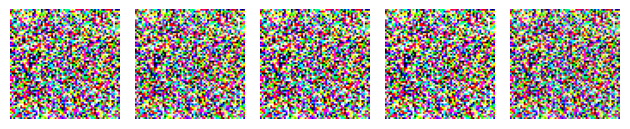

Epoch:  10
Epoch 10, Discriminator Loss: 3.3007214069366455, Generator Loss: 4.7713470458984375


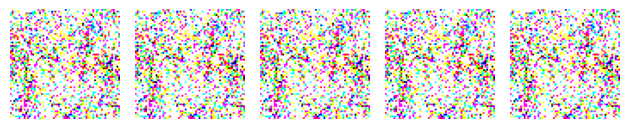

Epoch:  20
Epoch 20, Discriminator Loss: 0.1747860312461853, Generator Loss: 5.141667366027832


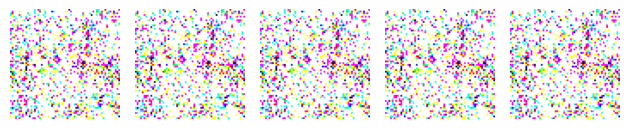

Epoch:  30
Epoch 30, Discriminator Loss: 0.16677981615066528, Generator Loss: 7.686115264892578


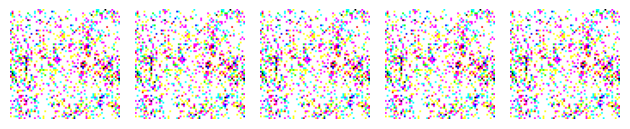

Epoch:  40
Epoch 40, Discriminator Loss: 100.10436248779297, Generator Loss: 0.7496320605278015


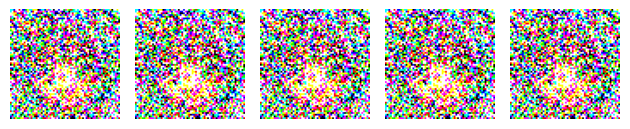

Epoch:  50
Epoch 50, Discriminator Loss: 0.23839280009269714, Generator Loss: 5.278275489807129


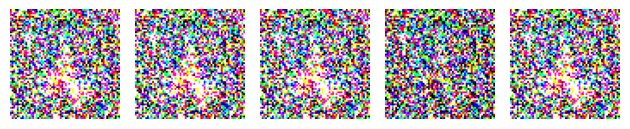

Epoch:  60
Epoch 60, Discriminator Loss: 0.20197142660617828, Generator Loss: 5.315540313720703


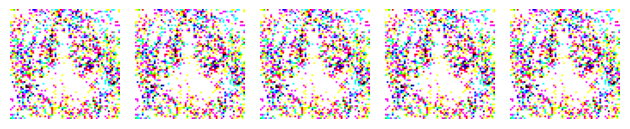

Epoch:  70
Epoch 70, Discriminator Loss: 0.22021326422691345, Generator Loss: 5.240035057067871


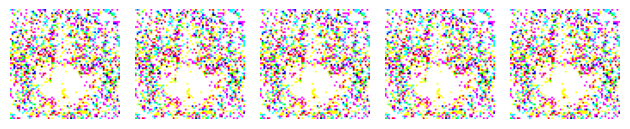

Epoch:  80
Epoch 80, Discriminator Loss: 0.8279581069946289, Generator Loss: 3.050945997238159


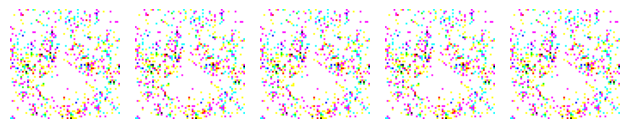

Epoch:  90
Epoch 90, Discriminator Loss: 0.3580054044723511, Generator Loss: 3.3906750679016113


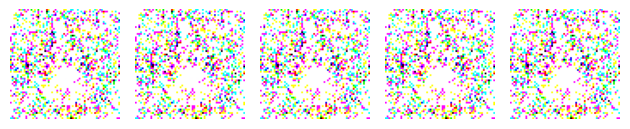

Epoch:  100
Epoch 100, Discriminator Loss: 5.4920148849487305, Generator Loss: 3.5816550254821777


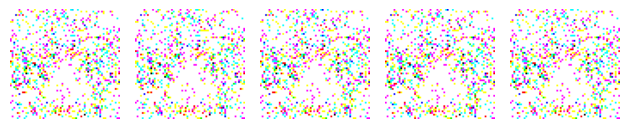

In [57]:
def train_model(generator, discriminator, gan, X_train, latent_dim, epochs, batch_size):
    discrim_losses = []
    generator_losses = []
    num_batches = int(X_train.shape[0] / batch_size)

    for ep in range(epochs + 1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            generated_images = generator.predict(noise, verbose=0)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, y_gen)
            generator_losses.append(gan_loss)

        if ep % 10 == 0:
            print('Epoch: ', ep)
            print(f'Epoch {ep}, Discriminator Loss: {d_loss}, Generator Loss: {gan_loss}')
            plot_generated_images(generator)

#Params
epochs = 100
batch_size = 16

#Train and create model
discriminator = build_discriminator(img_size)
generator = build_generator(latent_dim, img_size)

discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = models.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001))

train_model(generator, discriminator, gan, X_train, latent_dim, epochs, batch_size)